In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')

In [3]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.1 MB 11.5 MB/s 
     |████████████████████████████████| 3.3 MB 27.9 MB/s 
     |████████████████████████████████| 1.2 MB 35.6 MB/s 
     |████████████████████████████████| 61 kB 517 kB/s 
     |████████████████████████████████| 895 kB 35.8 MB/s 
     |████████████████████████████████| 596 kB 30.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=e745a83950ac15dfc7625136520cf8fb18738d4a85b870986717357fcd64a7a8
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [4]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *
from sklearn.cluster import DBSCAN
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer

In [5]:
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text', 'entities']].groupby(df.created_at.dt.to_period("M")).head(160)
#sub = df.groupby(df.created_at.dt.to_period("M")).head(100)
df = sub
text = df['text']
len(df)

Reading data/dkpol_tweets.jsonl


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


4480

In [6]:
text_without_processing = replace_url(df['text'], replacement = 'URL')

In [11]:
encoder = SentenceTransformer('Maltehb/danish-bert-botxo')
embeddings = encoder.encode(text_without_processing, show_progress_bar=True, normalize_embeddings = False)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_danish-bert-botxo were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/140 [00:00<?, ?it/s]

In [12]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings)

In [13]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(umap_embeddings)

In [14]:
print(Counter(cluster.labels_))

Counter({8: 3920, 7: 247, 4: 100, 0: 43, 9: 37, 3: 32, 6: 22, -1: 22, 1: 20, 2: 20, 5: 17})


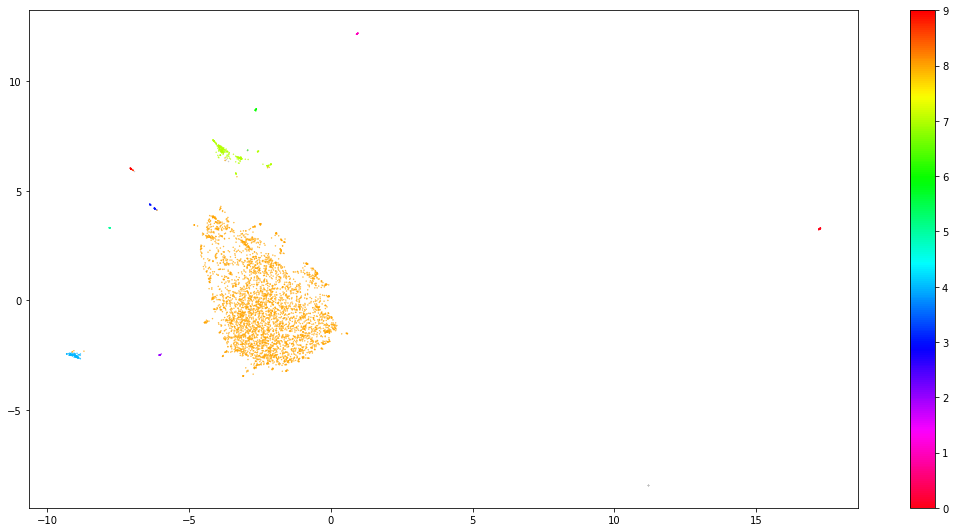

In [15]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [16]:
with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]

def remove_stopwords(token: str) -> str:
    return token if token not in stopwords else ''

def remove_newlines(text: str) -> str:
    return re.sub(r'\n+', ' ', text)

def remove_numbers(text, str) -> str:
    return re.sub(r'\d+', '', text)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)

import string 
    
def remove_punctuation(text: str) -> str:
    """BUT DO NOT REMOVE HASHTAGS OR MENTIONS"""
    regexp = re.compile(r'([#@]\w+)')
    return text if regexp.search(text) else re.sub(f'[{string.punctuation}]', '', text)


def is_website_token(token: str) -> str:
    if token[:4] == 'http':
        return ''
    else:
        return token

def remove_standalone_numbers(text: str) -> str:
    return re.sub(f'(?<!\S)\d+(?!\S)', '', text)

def split_by_space(text: str) -> List[str]:
    return text.split(' ')

In [17]:
tweet_tokenizer = TweetTokenizer().tokenize
tokenizer = TweetTokenizer()

text_list = list(text.values)

tokenized_text = [[token for token in tokenizer.tokenize(i)] for i in text_list]

print(tokenized_text[:2])

preprocessing_func = [remove_punctuation, str.lower, is_website_token, remove_stopwords, remove_standalone_numbers]

all_tokenizer_text = []

for token_text in tokenized_text:
    post_processed = []
    for token in token_text:
        for function in preprocessing_func:
            token = function(token)
        if token != '':
            post_processed.append(token)
    all_tokenizer_text.append(' '.join(post_processed))

print(all_tokenizer_text[:2])
print(len(all_tokenizer_text))

[['Det', 'er', 'på', 'tide', 'køreprøver', 'kommer', 'i', 'konkurrence', 'og', 'på', 'private', 'hænder', '.', 'Ligesom', 'med', 'bilsyn', '.', 'Væk', 'med', 'ventetider', 'og', 'styrket', 'kvaliteten', '.', '#dkpol', 'https://t.co/YfmAvrkwQu'], ['Min', 'klumme', 'i', '@berlingske', '"', 'I', 'utallige', 'år', ',', 'især', 'op', 'til', 'valgkampe', ',', 'har', 'der', 'været', 'fokus', 'på', 'jobcentrene', 'og', 'beskæftigelsesindsatsen', '.', 'Guld', 'og', 'grønne', 'skove', 'er', 'lovet', ',', 'men', 'alt', 'er', 'lige', 'så', 'gudsforladt', 'og', 'dysfunktionelt', 'som', 'altid', '.', '"', '#dkpol', '#dkmedier', 'https://t.co/GsZjYE2rGl']]
['tide køreprøver konkurrence private hænder bilsyn væk ventetider styrket kvaliteten #dkpol', 'klumme @berlingske utallige år især valgkampe fokus jobcentrene beskæftigelsesindsatsen guld grønne skove lovet gudsforladt dysfunktionelt #dkpol #dkmedier']
4480


In [18]:
print(len(all_tokenizer_text))
print(len(list(text.values)))

4480
4480


In [19]:
docs_df = pd.DataFrame(all_tokenizer_text , columns=["Doc"])
docs_df['Original Docs'] = list(text.values)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

#### Group by topic and select a sample

In [34]:
docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/dkpol_large_clusters.json')

### Tf-idf on docs from each cluster

In [21]:
def c_tf_idf(documents, m, ngram_range=(1, 3)):
    count = CountVectorizer(tokenizer = split_by_space, stop_words = None, ngram_range = (1,1)).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [23]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(200)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
9,8,3920
8,7,247
5,4,100
1,0,43
10,9,37
4,3,32
0,-1,22
7,6,22
2,1,20
3,2,20


In [36]:
def save_json(path: Path, container) -> None:
    """write dict to path."""
    print(f"Saving json to {path}")
    with open(path, "w") as outfile:
        json.dump(container, outfile)

In [37]:
len(top_n_words)
top_n_words[5]
import json
save_json('data/top_n_words_large_cluster.json', top_n_words)

Saving json to data/top_n_words_large_cluster.json


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(8):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

In [ ]:
# Get topic ids of alle clusters with more than 200 documents
topic_subset = topic_sizes[topic_sizes.Doc > 100]
topic_subset = list(topic_subset.Topic.values)

In [ ]:
print(topic_subset)
len(top_n_words)
print(topic_sizes.head(20))
print(top_n_words.keys())

### Reduce large clusters

Counter({20: 856, 21: 482, 4: 338, 14: 300, 12: 294, 22: 276, -1: 254, 16: 253, 19: 195, 9: 117, 5: 108, 18: 92, 10: 89, 15: 50, 11: 36, 13: 32, 8: 27, 7: 24, 0: 21, 6: 18, 17: 18, 2: 16, 1: 13, 3: 11})


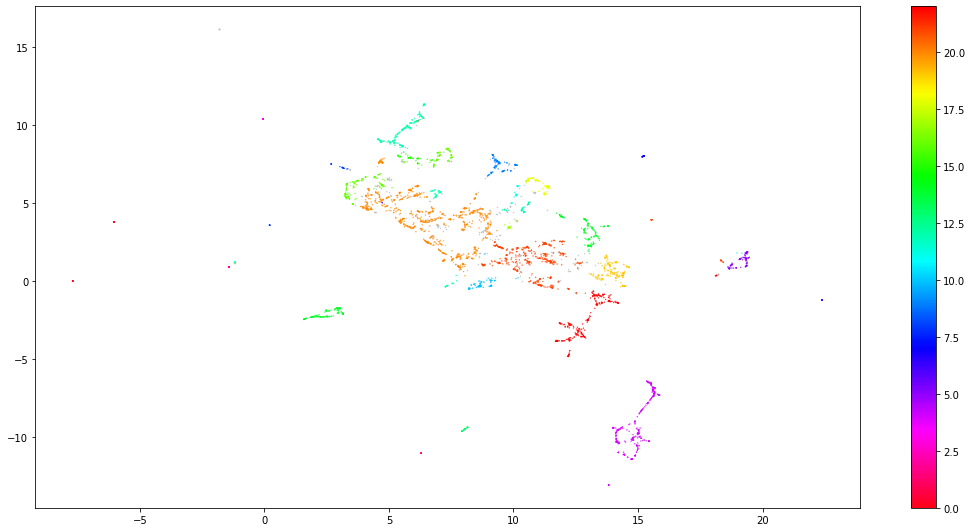

In [38]:
# Reduce large clusters

# Get large cluster idx
large_cluster_idx = [idx for idx, label in enumerate(cluster.labels_) if label == 8]
large_cluster_embeddings = umap_embeddings[large_cluster_idx,:]

# Reduce dim
large_umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(large_cluster_embeddings)


large_cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(large_umap_embeddings)

print(Counter(large_cluster.labels_))

# Prepare data
large_umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(large_cluster_embeddings)
large_result = pd.DataFrame(large_umap_data, columns=['x', 'y'])
large_result['labels'] = large_cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = large_result.loc[large_result.labels == -1, :]
clustered = large_result.loc[large_result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [40]:
docs_df = pd.DataFrame([all_tokenizer_text[i] for i in large_cluster_idx] , columns=["Doc"])
docs_df['Original Docs'] = [list(text.values)[i] for i in large_cluster_idx]
docs_df['Topic'] = large_cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/dkpol_small_subclusters.json')

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
21,20,856
22,21,482
5,4,338
15,14,300
13,12,294
23,22,276
0,-1,254
17,16,253
20,19,195
10,9,117


In [46]:
top_n_words[22]

[('#dkpol', 0.4176768999284237),
 ('#dkmedier', 0.07458438112000375),
 ('@larsloekke', 0.05465594313729313),
 ('@venstredk', 0.0300232106829857),
 ('’', 0.028293719302024463),
 ('the', 0.02811200798462222),
 ('😳', 0.027396688031470825),
 ('#covid19dk', 0.026913858658140603),
 ('…', 0.02673155033665063),
 ('😂', 0.026401108766267226),
 ('\u2069', 0.023985210965938763),
 ('mette', 0.0237171253421518),
 ('\u2066', 0.023674458748638876),
 ('@regeringdk', 0.022721546076948197),
 ('tak', 0.02205815402128568),
 ('#dkgreen', 0.02041598755414867),
 ('kender', 0.020196728584089697),
 ('#fv19', 0.020048662752487973),
 ('👇', 0.019569062879622016),
 ('spændende', 0.0193917710802112),
 ('snart', 0.01930782055434692),
 ('vist', 0.01922671636373524),
 ('@sorenpape', 0.019072317987808035),
 ('️', 0.019021379329180098),
 ('vej', 0.01885793483304802),
 ('hedder', 0.01791104933975818),
 ('#eupol', 0.017865246191749673),
 ('set', 0.0177766307092608),
 ('mon', 0.01737697978901399),
 ('danmark', 0.01713848233

In [47]:
save_json('data/top_n_words_small_subcluster.json', top_n_words)

Saving json to data/top_n_words_small_subcluster.json
